### Classification of sushi, steak and pizza

Following the code providing by [mrdbourke](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb) and its dataset

In [56]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import DataLoader
import os
import torchinfo
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

print(f"{torch.__version__}, {torchvision.__version__}")

2.4.0+rocm6.1, 0.19.0+rocm6.1


Lets see one image

h: 512, w: 382


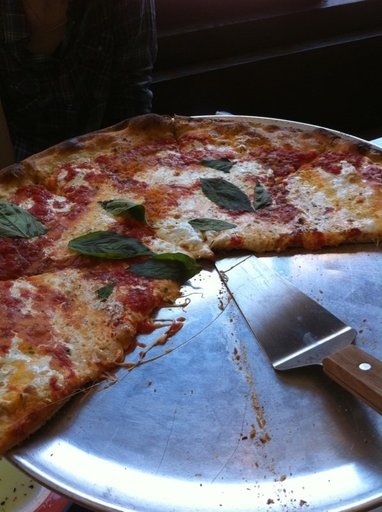

In [5]:
test_image = Image.open("./datasets/pizza_sushi/test/pizza/194643.jpg")
print(f"h: {test_image.height}, w: {test_image.width}")
test_image

Its a little large image for a model, can we compress it without losing information? Lets try with a transformation

In [10]:
data_transformer = transforms.Compose([
    transforms.Resize((64, 64)), #Resize the image to 64x64 pixels
    transforms.RandomHorizontalFlip(0.5), #Flip the image, 0.5 is the probality, its helps the model
    #To generalize the class
    transforms.ToTensor() #Converts and nomrmalize the values to a float tensor between 0 and 1
])

torch.Size([64, 64, 3])


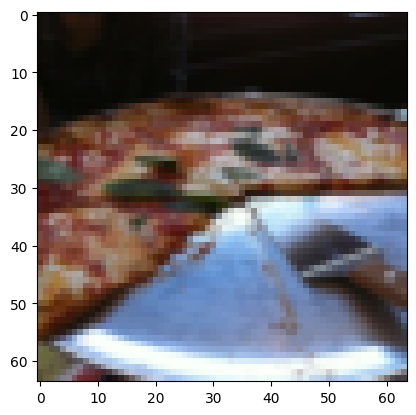

In [14]:
transformed_image = data_transformer(test_image).permute(1, 2, 0) #The permute is just for showing in matplotlib
print(transformed_image.shape)
plt.imshow(transformed_image)

### Lets load all the images and transform the images

In [72]:
train_dir = "./datasets/pizza_sushi/train"
test_dir = "./datasets/pizza_sushi/test"

In [15]:
train_data = datasets.ImageFolder("./datasets/pizza_sushi/train",data_transformer,None)
test_data = datasets.ImageFolder("./datasets/pizza_sushi/test",data_transformer,None)

In [17]:
print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: ./datasets/pizza_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 75
    Root location: ./datasets/pizza_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


It has all the values that we need to train the model?

In [24]:
classes = train_data.classes
classes

['pizza', 'steak', 'sushi']

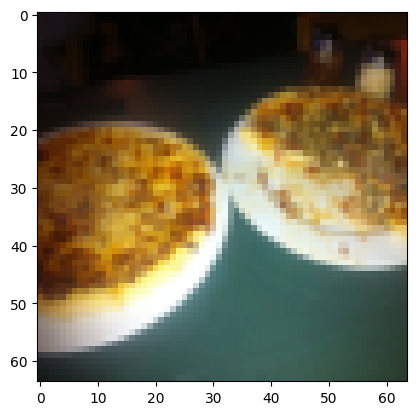

In [22]:
plt.imshow(train_data[0][0].permute(1, 2, 0))

In [26]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

So we now hoy it encode the information, lets check it

In [25]:
train_data[0][1]

0

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Lets create a dataloader object, to train the model, remember the batch training is the best, but in this case, because we have a little dataset, we are going to use a 1 batch

In [34]:
workers = os.cpu_count()
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size, False, num_workers=workers)
test_dataloader = DataLoader(test_data, batch_size, False, num_workers=workers)

In [35]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

Coping TinyVGG

In [36]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(23)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Lets try the model

In [38]:
model_0.eval()
with torch.inference_mode():
    logit = model_0(img[0].unsqueeze(0).to(device))
    pred = torch.softmax(logit, 1).argmax(1)

print(f"model pred: {pred}, actual label {label[0]}")

model pred: tensor([0], device='cuda:0'), actual label 0


Well it guess it right, what a fluke

Lets see the model more pretty

In [40]:
torchinfo.summary(model_0)

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      7,683
Total params: 10,693
Trainable params: 10,693
Non-trainable params: 0

Lets create a train and test functions

In [51]:

def train_func(model: nn.Module, data: torch.utils.data.DataLoader, loss_fn:nn.Module,
               optimizer: torch.optim.Optimizer, device: torch.device=device):
    model.eval()
    train_loss, train_acc = 0, 0
    for bathc, (X, y) in enumerate(data):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        loss = loss_fn(y_logit, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred = torch.softmax(y_logit, 1).argmax(1)
        train_acc += (y_pred == y).sum().item() / len (y_pred) #We can use another function if we want
    train_loss = train_loss / len(data)
    train_acc = train_acc / len(data)
    return train_loss, train_acc

In [66]:
def test_func(model: nn.Module, data: DataLoader, loss_fn: nn.Module, device: torch.device=device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data):
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()
            y_pred = y_logits.argmax(1)
            test_acc += (y_pred == y).sum().item() / len (y_pred) #We can use another function if we want
    test_loss = test_loss / len(data)
    test_acc = test_acc / len(data)
    return test_loss, test_acc

Lets combine all together in a function

In [68]:
def train(
        model: nn.Module, test_data: DataLoader, train_data: DataLoader, loss_fn:nn.Module,
        optimizer: torch.optim.Optimizer, device: torch.device=device, epochs: int =10
):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_func(
            model,train_data,loss_fn,optimizer
        )
        test_loss, test_acc = test_func(
            model, test_data, loss_fn
        )
        print(
            f"Epoch {epoch+1} |"
            f"train_loss :{train_loss: .4f} |"
            f"train_acc :{train_acc: .4f} |"
            f"test_loss :{test_loss: .4f} |"
            f"test_loss :{test_acc: .4f} "
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

Lets create the loss_fn and the optimizer

In [44]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [69]:
epochs = 10
model_0_results = train(model_0, test_dataloader, train_dataloader, loss_fn, optimizer,epochs=10)

 10%|█         | 1/10 [00:01<00:13,  1.54s/it]

Epoch 1 |train_loss : 1.0950 |train_acc : 0.4023 |test_loss : 1.0598 |test_loss : 0.5417 


 20%|██        | 2/10 [00:02<00:11,  1.45s/it]

Epoch 2 |train_loss : 1.0943 |train_acc : 0.4023 |test_loss : 1.0599 |test_loss : 0.5417 


 30%|███       | 3/10 [00:04<00:10,  1.44s/it]

Epoch 3 |train_loss : 1.0942 |train_acc : 0.4023 |test_loss : 1.0597 |test_loss : 0.5417 


 40%|████      | 4/10 [00:05<00:08,  1.41s/it]

Epoch 4 |train_loss : 1.0937 |train_acc : 0.4023 |test_loss : 1.0598 |test_loss : 0.5417 


 50%|█████     | 5/10 [00:07<00:06,  1.39s/it]

Epoch 5 |train_loss : 1.0934 |train_acc : 0.4023 |test_loss : 1.0597 |test_loss : 0.5417 


 60%|██████    | 6/10 [00:08<00:05,  1.38s/it]

Epoch 6 |train_loss : 1.0929 |train_acc : 0.4023 |test_loss : 1.0595 |test_loss : 0.5417 


 70%|███████   | 7/10 [00:09<00:04,  1.40s/it]

Epoch 7 |train_loss : 1.0925 |train_acc : 0.4023 |test_loss : 1.0595 |test_loss : 0.5417 


 80%|████████  | 8/10 [00:11<00:02,  1.40s/it]

Epoch 8 |train_loss : 1.0922 |train_acc : 0.4023 |test_loss : 1.0591 |test_loss : 0.5417 


 90%|█████████ | 9/10 [00:12<00:01,  1.40s/it]

Epoch 9 |train_loss : 1.0917 |train_acc : 0.4023 |test_loss : 1.0588 |test_loss : 0.5417 


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

Epoch 10 |train_loss : 1.0913 |train_acc : 0.4023 |test_loss : 1.0583 |test_loss : 0.5417 


In [62]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

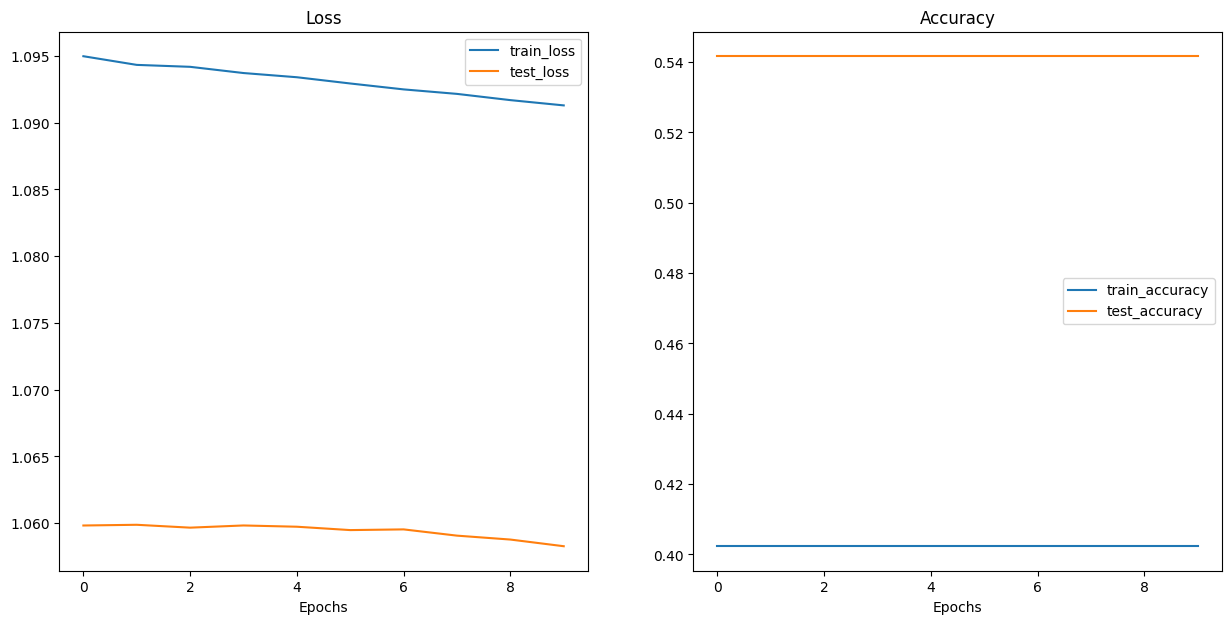

In [70]:
plot_loss_curves(model_0_results)

Lets try Data argumentation, it creates additional examples based in the original ones, that has the same features, it uses techniques such as rotation, reflection and transformation of the images without losing the features 

In [71]:
train_argumentation = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_argumentation = transforms.Compose([ #In this case we dont need to create new artificial iamges
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [73]:
train_data_argumentation = datasets.ImageFolder(train_dir, train_argumentation)
test_data_simple = datasets.ImageFolder(test_dir, test_argumentation)
train_data_argumentation, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: ./datasets/pizza_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: ./datasets/pizza_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [81]:
train_dataloader_argumentation = DataLoader(train_data_argumentation, batch_size, False, num_workers=workers )
test_dataloader_argumentation = DataLoader(test_data_simple, batch_size, False, num_workers=workers )
train_dataloader_argumentation, test_dataloader_argumentation

(<torch.utils.data.dataloader.DataLoader at 0x7add60d25f10>,
 <torch.utils.data.dataloader.DataLoader at 0x7add950e75f0>)

In [78]:
model_1 = TinyVGG(3, 10, 3).to(device)
torchinfo.summary(model_1)

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      7,683
Total params: 10,693
Trainable params: 10,693
Non-trainable params: 0

In [104]:
torch.manual_seed(23)
torch.cuda.manual_seed(23)

epochs = 20

optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

model_1_results = train(model_1, test_dataloader_argumentation, train_dataloader_argumentation, 
                        loss_fn, optimizer, epochs=epochs)

  5%|▌         | 1/20 [00:01<00:26,  1.40s/it]

Epoch 1 |train_loss : 1.0931 |train_acc : 0.4023 |test_loss : 1.0743 |test_loss : 0.5417 


 10%|█         | 2/20 [00:02<00:25,  1.39s/it]

Epoch 2 |train_loss : 1.0920 |train_acc : 0.4023 |test_loss : 1.0742 |test_loss : 0.5417 


 15%|█▌        | 3/20 [00:04<00:24,  1.42s/it]

Epoch 3 |train_loss : 1.0919 |train_acc : 0.4023 |test_loss : 1.0741 |test_loss : 0.5417 


 20%|██        | 4/20 [00:05<00:23,  1.45s/it]

Epoch 4 |train_loss : 1.0918 |train_acc : 0.4023 |test_loss : 1.0739 |test_loss : 0.5417 


 25%|██▌       | 5/20 [00:07<00:21,  1.44s/it]

Epoch 5 |train_loss : 1.0917 |train_acc : 0.4023 |test_loss : 1.0737 |test_loss : 0.5417 


 30%|███       | 6/20 [00:08<00:20,  1.44s/it]

Epoch 6 |train_loss : 1.0917 |train_acc : 0.4023 |test_loss : 1.0735 |test_loss : 0.5417 


 35%|███▌      | 7/20 [00:10<00:18,  1.45s/it]

Epoch 7 |train_loss : 1.0916 |train_acc : 0.4023 |test_loss : 1.0733 |test_loss : 0.5417 


 40%|████      | 8/20 [00:11<00:17,  1.46s/it]

Epoch 8 |train_loss : 1.0916 |train_acc : 0.4023 |test_loss : 1.0731 |test_loss : 0.5417 


 45%|████▌     | 9/20 [00:12<00:16,  1.46s/it]

Epoch 9 |train_loss : 1.0915 |train_acc : 0.4023 |test_loss : 1.0729 |test_loss : 0.5417 


 50%|█████     | 10/20 [00:14<00:14,  1.46s/it]

Epoch 10 |train_loss : 1.0915 |train_acc : 0.4023 |test_loss : 1.0727 |test_loss : 0.5417 


 55%|█████▌    | 11/20 [00:15<00:13,  1.45s/it]

Epoch 11 |train_loss : 1.0914 |train_acc : 0.4023 |test_loss : 1.0725 |test_loss : 0.5417 


 60%|██████    | 12/20 [00:17<00:11,  1.45s/it]

Epoch 12 |train_loss : 1.0914 |train_acc : 0.4023 |test_loss : 1.0723 |test_loss : 0.5417 


 65%|██████▌   | 13/20 [00:18<00:10,  1.46s/it]

Epoch 13 |train_loss : 1.0914 |train_acc : 0.4023 |test_loss : 1.0721 |test_loss : 0.5417 


 70%|███████   | 14/20 [00:20<00:08,  1.48s/it]

Epoch 14 |train_loss : 1.0913 |train_acc : 0.4023 |test_loss : 1.0719 |test_loss : 0.5417 


 75%|███████▌  | 15/20 [00:21<00:07,  1.47s/it]

Epoch 15 |train_loss : 1.0913 |train_acc : 0.4023 |test_loss : 1.0718 |test_loss : 0.5417 


 80%|████████  | 16/20 [00:23<00:05,  1.47s/it]

Epoch 16 |train_loss : 1.0912 |train_acc : 0.4023 |test_loss : 1.0716 |test_loss : 0.5417 


 85%|████████▌ | 17/20 [00:24<00:04,  1.48s/it]

Epoch 17 |train_loss : 1.0912 |train_acc : 0.4023 |test_loss : 1.0714 |test_loss : 0.5417 


 90%|█████████ | 18/20 [00:26<00:02,  1.47s/it]

Epoch 18 |train_loss : 1.0912 |train_acc : 0.4023 |test_loss : 1.0712 |test_loss : 0.5417 


 95%|█████████▌| 19/20 [00:27<00:01,  1.48s/it]

Epoch 19 |train_loss : 1.0911 |train_acc : 0.4023 |test_loss : 1.0710 |test_loss : 0.5417 


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]

Epoch 20 |train_loss : 1.0911 |train_acc : 0.4023 |test_loss : 1.0708 |test_loss : 0.5417 


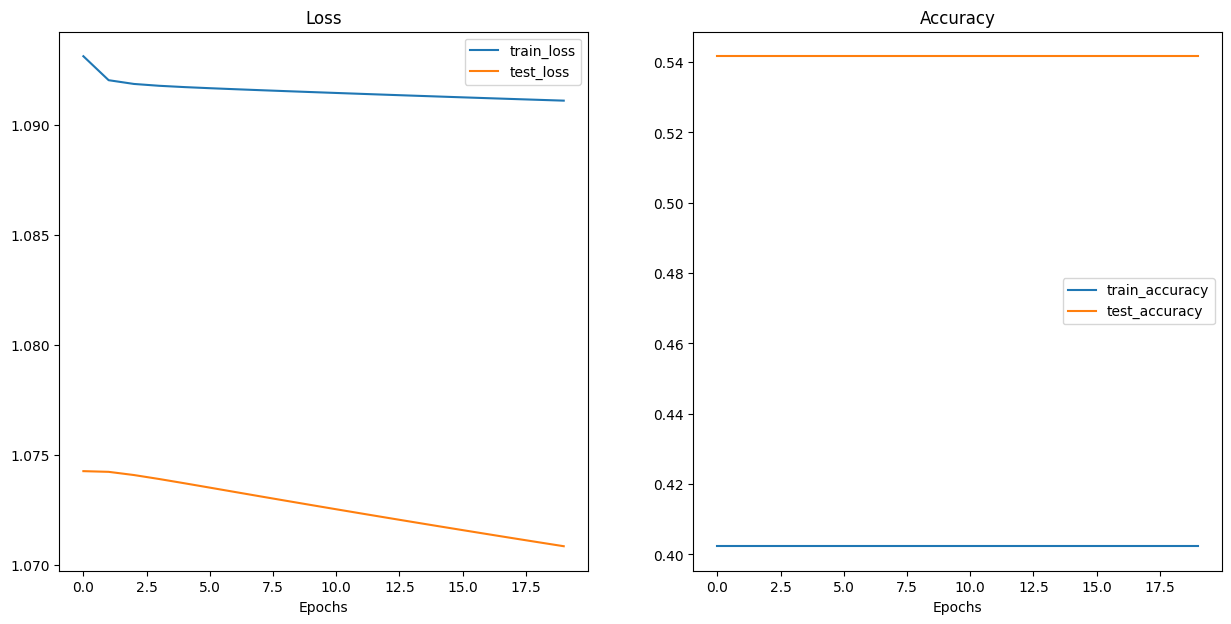

In [105]:
plot_loss_curves(model_1_results)

Well is just a right model don't? or we can improve, for the graphs it doest seem that is underfitting or overfitting

Lets try with a custom image

In [106]:
torch.save(model_1, "../models/FoodModel.pth")

h: 512, w: 382


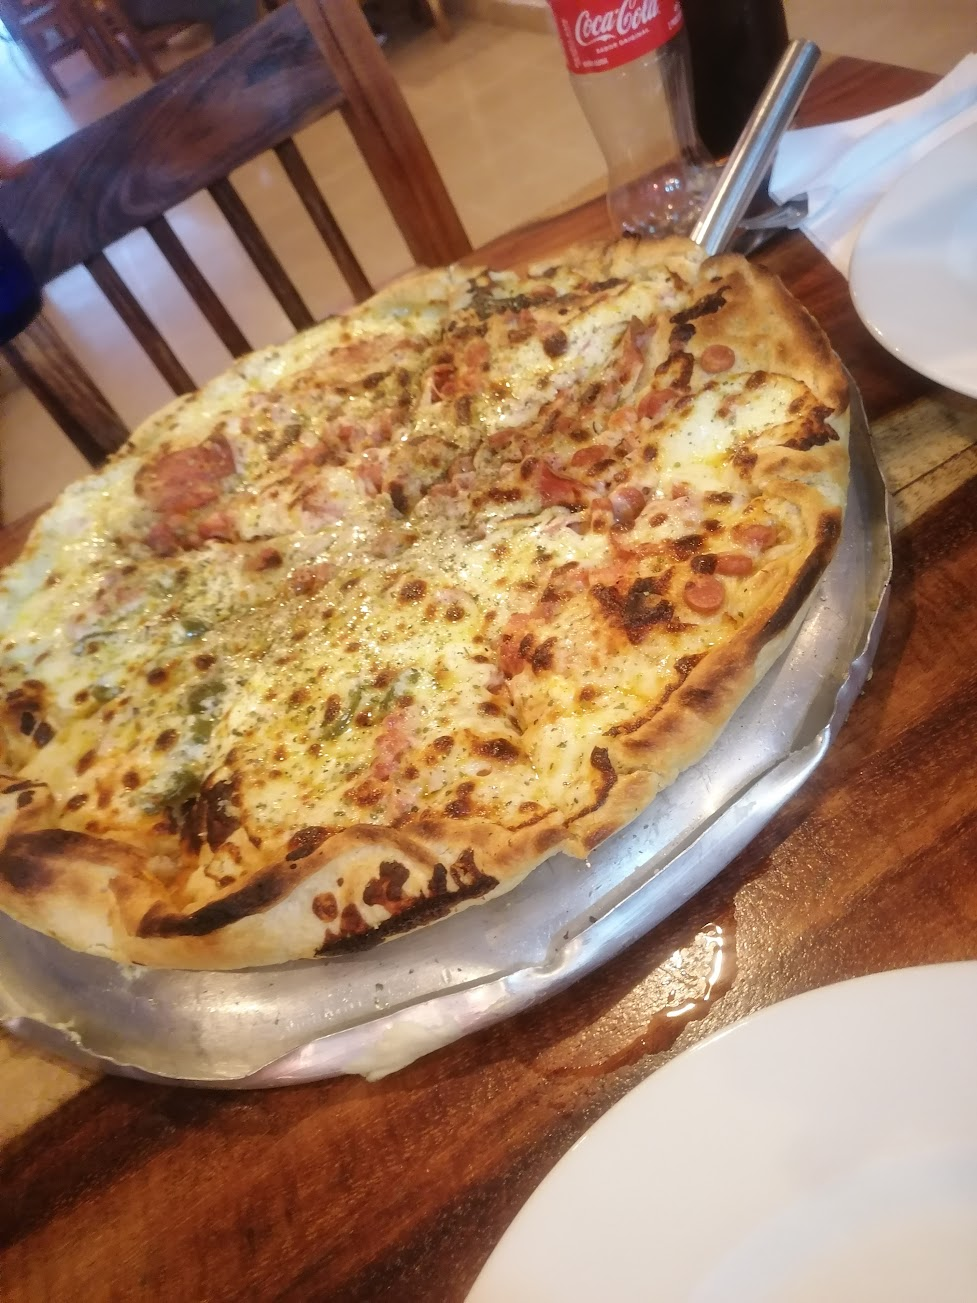

In [87]:
img = Image.open("./datasets/pizza_sushi/custom_image.jpg")
print(f"h: {test_image.height}, w: {test_image.width}")
img

Lets transform and eval if the model can predict

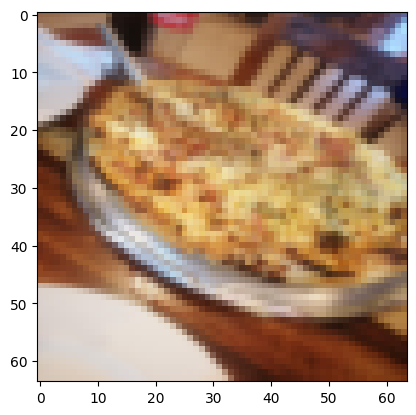

In [92]:
img_transform = data_transformer(img)
plt.imshow(img_transform.permute(1, 2, 0))

In [90]:
model_1.eval()
with torch.inference_mode():
    y_pred = model_1(img_transform.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

Remember to add the batch size, because we train the model with that in mind so 

In [93]:
img_transform = img_transform.unsqueeze(0).to(device)
img_transform.shape

torch.Size([1, 3, 64, 64])

In [107]:
model_1.eval()
with torch.inference_mode():
    y_logit = model_1(img_transform.to(device))

In [108]:
y_pred_prob = torch.softmax(y_logit, 1)
y_pred = y_pred_prob.argmax(1)
print(f"its a {classes[y_pred.cpu().item()]}, with a {y_pred_prob.max() * 100: .3f} confidence")

its a sushi, with a  36.614 confidence


A good sushi huh